In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

In [1]:
import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/opt/scripts/des.mplstyle')

# Initial Setup

In [6]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT200_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT290_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT350_HprodAst_Lx3000km'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT200_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT290_HprodAst_Lx3000km_ck'
scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT290_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT350_HprodAst_Lx4000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT290_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
print(f'Model Path: {model_path}')

model_name = os.path.split(model_path)[1]
print(f'Model name: {model_name}')

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(f'Output Path: {output_path}')

if not os.path.isdir(output_path):
    os.makedirs(output_path)

Model Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck
Model name: keel_stable_DT350_HprodAst_Lx3000km_ck
Output Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck/_output


# Reading Dataset

In [7]:
dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 301, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.0 994.5 997.0 999.5
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 2.98e+06 2.99e+06 3e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                301
    nz:                                71
    lx:                                3000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_u

In [8]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean
def Tp_estimate(mean_temp, z, zbot, ztop):
    zcond = (z<=zbot+40) & (z>=ztop+40) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b


data = dataset.temperature[-1].values.T #Nz vs Nx

#selecting regions
#Calculating mean temperature profile for different regions
xcenter = (Lx/2)/1.0e3
keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 600, xcenter - 200)
keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 100, xcenter + 100)
keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 200, xcenter + 600)

Tp_keel_l, fit_keel_l = Tp_estimate(keel_mean_l, z, 600, 300)
Tp_keel_c, fit_keel_c = Tp_estimate(keel_mean_c, z, 600, 300)
Tp_keel_r, fit_keel_r = Tp_estimate(keel_mean_r, z, 600, 300)


out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - 800)
out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 800, Lx/1.03 - 200)

Tp_out_l, fit_out_l = Tp_estimate(out_mean_l, z, 600, 200)
Tp_out_r, fit_out_r = Tp_estimate(out_mean_r, z, 600, 150)

# Plot single profiles

Tp_estimate_keel_stable_DT350_HprodAst_Lx3000km_ck_individual


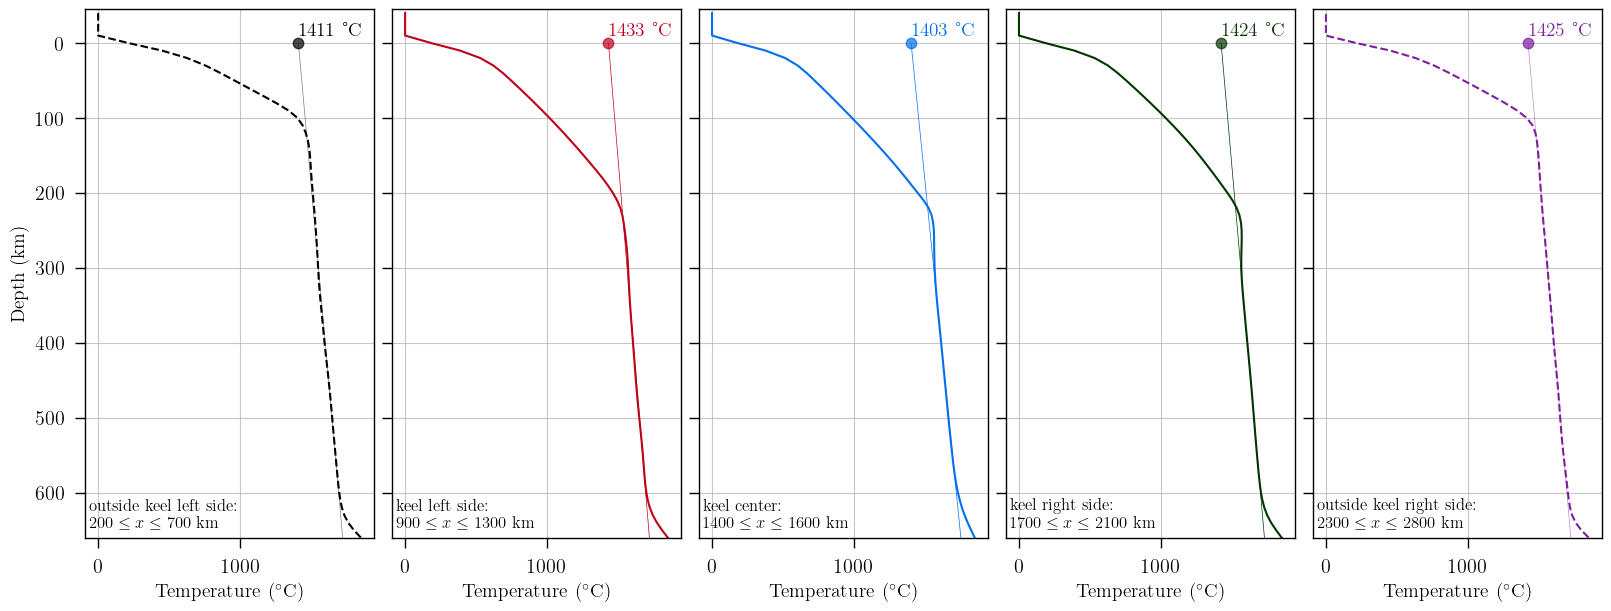

In [9]:
plt.close()            
fig, axs = plt.subplots(1, 5, figsize=(16,6), sharex=True, sharey=True, constrained_layout=True)

axs[0].plot(out_mean_l, z-40, linestyle='--', color = 'xkcd:black', label = r'out left side: $200 \leq x \leq 700$ km')
axs[1].plot(keel_mean_l, z-40, linestyle='-', color = 'xkcd:scarlet', label = r'keel left side: $900 \leq x \leq 1300$ km')
axs[2].plot(keel_mean_c, z-40, linestyle='-', color='xkcd:cerulean blue', label = r'keel center: $1400 \leq x \leq 1600$ km')
axs[3].plot(keel_mean_r, z-40, linestyle='-', color = 'xkcd:dark green', label = r'keel right side: $1700 \leq x \leq 2100$ km')
axs[4].plot(out_mean_r, z-40, linestyle='--', color = 'xkcd:purple', label = r'out right side: $2300 \leq x \leq 2800$ km')

z_aux = z - 40

axs[0].plot(fit_out_l[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:black', alpha=0.5)
axs[1].plot(fit_keel_l[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:scarlet')
axs[2].plot(fit_keel_c[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color='xkcd:cerulean blue')
axs[3].plot(fit_keel_r[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:dark green')
axs[4].plot(fit_out_r[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color='xkcd:purple', alpha=0.5)

axs[0].plot(Tp_out_l, 0, marker='.', markersize=15, color = 'xkcd:black', alpha=0.7)
axs[1].plot(Tp_keel_l, 0, marker='.', markersize=15, color = 'xkcd:scarlet', alpha=0.7)
axs[2].plot(Tp_keel_c, 0, marker='.', markersize=15, color='xkcd:cerulean blue', alpha=0.7)
axs[3].plot(Tp_keel_r, 0, marker='.', markersize=15, color = 'xkcd:dark green', alpha=0.7)
axs[4].plot(Tp_out_r, 0, marker='.', markersize=15, color = 'xkcd:purple', alpha=0.7)

fsize = 14
yshift = 10
xshift = 5
rotation = 0

axs[0].text(Tp_out_l+xshift, 0-yshift, f'{Tp_out_l} °C', fontsize=fsize, color='xkcd:black', rotation=rotation)
axs[1].text(Tp_keel_l+xshift, 0-yshift, f'{Tp_keel_l} °C', fontsize=fsize, color='xkcd:scarlet', rotation=rotation)
axs[2].text(Tp_keel_c+xshift, 0-yshift, f'{Tp_keel_c} °C', fontsize=fsize, color='xkcd:cerulean blue', rotation=rotation)
axs[3].text(Tp_keel_r+xshift, 0-yshift, f'{Tp_keel_r} °C', fontsize=fsize, color='xkcd:dark green', rotation=rotation)
axs[4].text(Tp_out_r+xshift, 0-yshift, f'{Tp_out_r} °C', fontsize=fsize, color='xkcd:purple', rotation=rotation)

fsize = 14
xmin, xmax = 1300, 1700

locations = [f'outside keel left side:\n $200 \leq x \leq 700$ km',
             f'keel left side:\n $900 \leq x \leq 1300$ km',
             f'keel center:\n $1400 \leq x \leq 1600$ km',
             f'keel right side:\n $1700 \leq x \leq 2100$ km',
             f'outside keel right side:\n $2300 \leq x \leq 2800$ km'
            ]

for ax, location in zip(axs, locations):
    ax.set_xlabel(r'Temperature ($^{\circ}$C)', fontsize=fsize)
    ax.grid('-k', alpha=0.7)
    # ax.set_xlim(xmin, xmax)
    # ax.set_xticks(np.arange(xmin, xmax+100, 100))
    ax.text(0.015, 0.02, location, fontsize=12, transform=ax.transAxes)

axs[0].set_ylabel('Depth (km)', fontsize=fsize)
axs[0].set_ylim(660, -45)

figname = f'Tp_estimate_{model_name}_individual'
print(figname)
fig.savefig(f'out/plots/{figname}.png', dpi=400)
fig.savefig(f'out/plots/{figname}.pdf', dpi=400)
fig.savefig(f'{output_path}/{figname}.png', dpi=400)
fig.savefig(f'{output_path}/{figname}.pdf', dpi=400)

array([700., 690., 680., 670., 660., 650., 640., 630., 620., 610., 600.,
       590., 580., 570., 560., 550., 540., 530., 520., 510., 500., 490.,
       480., 470., 460., 450., 440., 430., 420., 410., 400., 390., 380.,
       370., 360., 350., 340., 330., 320., 310., 300., 290., 280., 270.,
       260., 250., 240., 230., 220., 210., 200., 190., 180., 170., 160.,
       150., 140., 130., 120., 110., 100.,  90.,  80.,  70.,  60.,  50.,
        40.,  30.,  20.,  10.,   0.])

(660.0, -40.0)

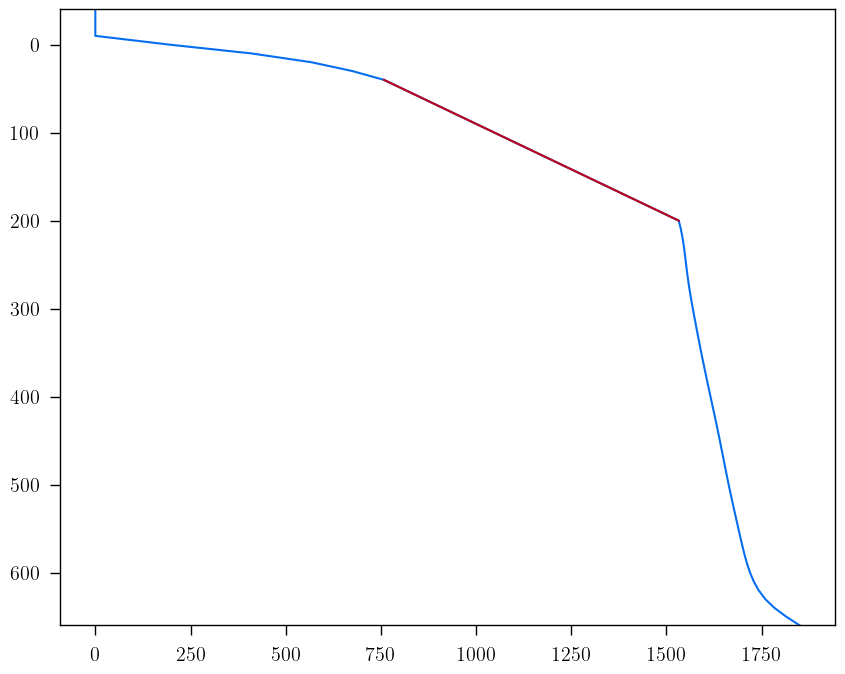

In [21]:
dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

# thickness of sticky air layer (m)
thickness_sa = 40 #* 1.0e3
# thickness of upper crust (m)
thickness_upper_crust = 20 #* 1.0e3
# thickness of lower crust (m)
thickness_lower_crust = 15 #* 1.0e3
# total thickness of lithosphere (m)
thickness_litho = 80 #* 1.0e3

thickening = thickness_litho + 120

T_initial = dataset.temperature[-1].values.T #.T = Nz vs Nx
Datai = dataset.temperature[-1].values.T
Ti_mean = calc_mean_temperaure_region(T_initial, Nz, xx, 0, 3000)

cond_mlit = (z <= thickening+thickness_sa) & (z >= thickness_sa + thickness_upper_crust + thickness_lower_crust)
         
T1 = Ti_mean[cond_mlit][0] #bottom
T0 = Ti_mean[cond_mlit][-1] #top
z1 = z[cond_mlit][0]
z0  = z[cond_mlit][-1]

Ti_mean[cond_mlit] = ((T1 - T0) / (z1 - z0)) * (z[cond_mlit] - z0) + T0


plt.close()
# plt.plot(T_initial[:, 0], z-40)
plt.plot(Ti_mean, z-40)
plt.plot(Ti_mean[cond_mlit], z[cond_mlit]-40, color='xkcd:scarlet')
plt.ylim(700-40, 0-40)

# plt.plot(T1, z1-40, '*', markersize=10)
# plt.plot(T0, z0-40, '*', markersize=10)

In [15]:
Ti_mean[cond_mlit][0], Ti_mean[cond_mlit][-1], z[cond_mlit][0], z[cond_mlit][-1] #top

(1492.82, 855.2090000000001, 240.0, 80.0)

# Plot all profiles together

Tp_estimate_keel_stable_DT350_HprodAst_Lx3000km_together


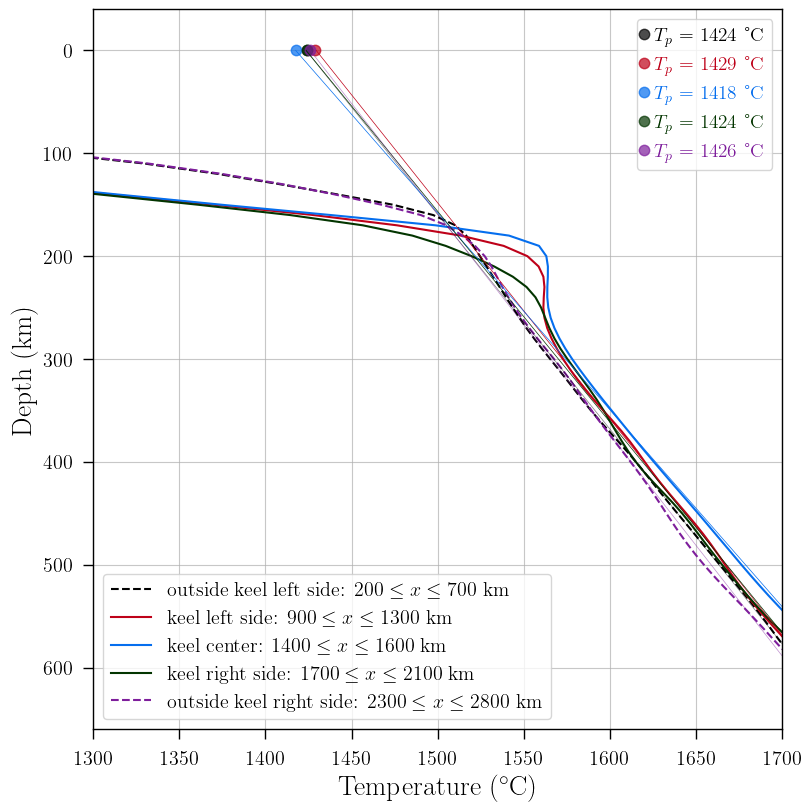

In [185]:
plt.close()            
fig, ax = plt.subplots(1, 1, figsize=(8,8), sharex=True, sharey=True, constrained_layout=True)

ax.plot(out_mean_l, z-40, linestyle='--', color = 'xkcd:black', label = r'outside keel left side: $200 \leq x \leq 700$ km')
ax.plot(keel_mean_l, z-40, linestyle='-', color = 'xkcd:scarlet', label = r'keel left side: $900 \leq x \leq 1300$ km')
ax.plot(keel_mean_c, z-40, linestyle='-', color='xkcd:cerulean blue', label = r'keel center: $1400 \leq x \leq 1600$ km')
ax.plot(keel_mean_r, z-40, linestyle='-', color = 'xkcd:dark green', label = r'keel right side: $1700 \leq x \leq 2100$ km')
ax.plot(out_mean_r, z-40, linestyle='--', color = 'xkcd:purple', label = r'outside keel right side: $2300 \leq x \leq 2800$ km')

z_aux = z - 40

ax.plot(Tp_out_l, 0, marker='.', markersize=15, color = 'xkcd:black', alpha=0.7)#, label=f'{Tp_out_l} °C')
ax.plot(Tp_keel_l, 0, marker='.', markersize=15, color = 'xkcd:scarlet', alpha=0.7)#, label=f'{Tp_keel_l} °C')
ax.plot(Tp_keel_c, 0, marker='.', markersize=15, color='xkcd:cerulean blue', alpha=0.7)#, label=f'{Tp_keel_c} °C')
ax.plot(Tp_keel_r, 0, marker='.', markersize=15, color = 'xkcd:dark green', alpha=0.7)#, label=f'{Tp_keel_r} °C')
ax.plot(Tp_out_r, 0, marker='.', markersize=15, color = 'xkcd:purple', alpha=0.7)#, label=f'{Tp_out_r} °C')

ax.plot(fit_out_l[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:black', alpha=0.5)
ax.plot(fit_keel_l[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:scarlet')
ax.plot(fit_keel_c[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color='xkcd:cerulean blue')
ax.plot(fit_keel_r[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color = 'xkcd:dark green')
ax.plot(fit_out_r[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.5, color='xkcd:purple', alpha=0.5)

# fsize = 14
# yshift = 10
# ax.text(Tp_keel_l, 0-yshift, f'{Tp_keel_l} °C', fontsize=fsize, color='xkcd:scarlet', rotation=45)
# ax.text(Tp_keel_c+5, 0-yshift, f'{Tp_keel_c} °C', fontsize=fsize, color='xkcd:cerulean blue', rotation=45)
# ax.text(Tp_keel_r+15, 0-yshift, f'{Tp_keel_r} °C', fontsize=fsize, color='xkcd:dark green', rotation=45)
# ax.text(Tp_out_l, 0-yshift, f'{Tp_out_l} °C', fontsize=fsize, color='xkcd:black', rotation=45)
# ax.text(Tp_out_r, 0-yshift, f'{Tp_out_r} °C', fontsize=fsize, color='xkcd:purple', rotation=45)

#set plot details
fsize = 20
ax.set_xlabel(r'Temperature ($^{\circ}$C)', fontsize=fsize)
ax.set_ylabel('Depth (km)', fontsize=fsize)
ax.grid('-k', alpha=0.7)
ax.set_xlim(1300, 1700)
ax.set_ylim(660, -40)
# ax.set_ylim(200, 0)

ax.legend(loc='lower left')

ax2 = ax.twinx()
ax2.axis('off')
ax2.plot(-10, -10, marker='.', markersize=15, color = 'xkcd:black', alpha=0.7, label=f'$T_p$ = {Tp_out_l} °C')
ax2.plot(-10, -10, marker='.', markersize=15, color = 'xkcd:scarlet', alpha=0.7, label=f'$T_p$ = {Tp_keel_l} °C')
ax2.plot(-10, -10, marker='.', markersize=15, color='xkcd:cerulean blue', alpha=0.7, label=f'$T_p$ = {Tp_keel_c} °C')
ax2.plot(-10, -10, marker='.', markersize=15, color = 'xkcd:dark green', alpha=0.7, label=f'$T_p$ = {Tp_keel_r} °C')
ax2.plot(-10, -10, marker='.', markersize=15, color = 'xkcd:purple', alpha=0.7, label=f'$T_p$ = {Tp_out_r} °C')
ax2.legend(loc='upper right', labelcolor='linecolor', handlelength=0, handletextpad=0.5, fontsize=14)

figname = f'Tp_estimate_{model_name}_together'
print(figname)
fig.savefig(f'out/plots/{figname}.png', dpi=400)
fig.savefig(f'out/plots/{figname}.pdf', dpi=400)
fig.savefig(f'{output_path}/{figname}.png', dpi=400)
fig.savefig(f'{output_path}/{figname}.pdf', dpi=400)

In [44]:
d = np.asarray(dataset.temperature[-1]).T

# np.shape(d)
d[xleft].reshape(Nz, len(xleft[0][xleft[0]==True]))

array([[1700.63 , 1700.63 , 1700.63 , 1700.63 , 1700.63 , 1700.63 ,
        1700.63 , 1700.63 , 1700.63 , 1700.63 , 1700.63 ],
       [1656.   , 1656.94 , 1657.85 , 1658.74 , 1659.61 , 1660.45 ,
        1661.23 , 1661.82 , 1662.37 , 1663.14 , 1664.03 ],
       [1619.18 , 1620.59 , 1621.99 , 1623.37 , 1624.72 , 1626.05 ,
        1627.31 , 1628.44 , 1629.55 , 1630.8  , 1632.09 ],
       [1593.98 , 1595.36 , 1596.74 , 1598.12 , 1599.51 , 1600.89 ,
        1602.26 , 1603.63 , 1605.04 , 1606.42 , 1607.7  ],
       [1579.26 , 1580.28 , 1581.34 , 1582.43 , 1583.56 , 1584.72 ,
        1585.91 , 1587.16 , 1588.46 , 1589.7  , 1590.86 ],
       [1571.64 , 1572.22 , 1572.85 , 1573.54 , 1574.29 , 1575.09 ,
        1575.95 , 1576.86 , 1577.82 , 1578.79 , 1579.77 ],
       [1567.99 , 1568.15 , 1568.36 , 1568.64 , 1568.99 , 1569.39 ,
        1569.85 , 1570.38 , 1570.97 , 1571.62 , 1572.33 ],
       [1566.15 , 1565.96 , 1565.82 , 1565.74 , 1565.71 , 1565.74 ,
        1565.82 , 1565.98 , 1566.21 , 1566.